線形回帰を行うときの重要な仮定は

* 残差が独立同分布になっている

である.  よく言われている条件

* 残差が正規分布に従うこと

は誤りである.  残差が正規分布に従うことは必要ないし, 残差の分布が正規分布に従っていても i.i.d. になっていなければ線形回帰の適用は不適切であると考えられる.

もちろん, 残差が正規分布以外の分布のi.i.d.になっている場合には, 誤差が大きくなることはありえるので要注意である.

残差が正規分布以外の分布のi.i.d.になっているように見える場合には, 観測していない独立変数に $y$ が非線形に依存している可能性を疑う必要があるかもしれない.

In [1]:
using Distributions
using Optim
using Random
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6, guidefontsize=8, legendfontsize=8)

β̂ = X \ y = [1.9846574337391234, 2.0207617778479086]


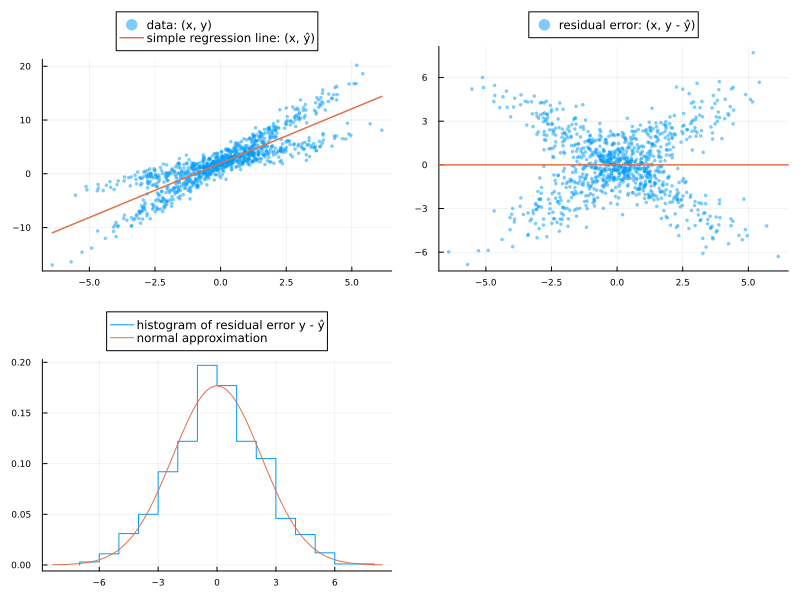

In [2]:
n = 10^3

distx = Normal(0, 2)

disty(x,a,b,c,d,s,t) = MixtureModel(
    [Normal(a + b*x, exp(s)), Normal(c + d*x , exp(t))],
    fill(1/2, 2))

w_true = Float64[2, 1, 2, 3, 0, 0]
x = rand(distx, n)
y = @. rand(disty(x, w_true...))
X = x .^ (0:1)'
@show β̂ = X \ y
ŷ = X * β̂

P1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
plot!(x -> [1,x]'*β̂; label="simple regression line: (x, ŷ)", lw=1.5)

P2 = scatter(x, y - ŷ; label="residual error: (x, y - ŷ)", msc=:auto, alpha=0.5, ms=2)
hline!([0]; label="", lw=1.5)

P3 = stephist(y - ŷ; norm=true, label="histogram of residual error y - ŷ")
plot!(fit(Normal, y - ŷ); label="normal approximation")

plot(P1, P2, P3; size=(800, 600), legend=:outertop, layout=(2, 2))

上のデータに単純に線形回帰を適用することは散布図より明らかだが, 残差の全体は正規分布に従っている.

  2.018111 seconds (3.87 M allocations: 267.914 MiB, 7.44% gc time)
o =  * Status: success

 * Candidate solution
    Final objective value:     -5.254852e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.46e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.58e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.48e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.23e-14 ≰ 0.0e+00
    |g(x)|                 = 1.37e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    19
    ∇f(x) calls:   19

(â, b̂, ĉ, d̂) = o.minimizer = [2.0623775040634946, 1.0667545076851082, 1.886874481927529, 2.8952312873932957]


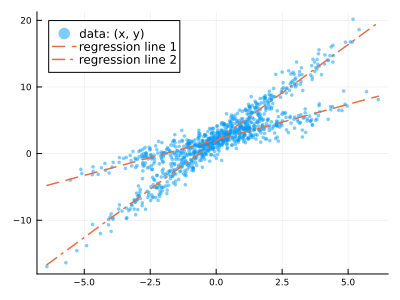

In [3]:
disty(x,a,b,c,d,s,t) = MixtureModel(
    [Normal(a + b*x, exp(s)), Normal(c + d*x , exp(t))],
    fill(1/2, 2))

negloglik(a, b, c, d, s, t) = -logsumexp(logpdf(disty(x,a,b,c,d,s,t), y) for (x, y) in zip(x, y))
@time o = optimize(w -> negloglik(w..., 0, 0), w_true[1:4], LBFGS())
@show o
@show â, b̂, ĉ, d̂ = o.minimizer

Q1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
plot!(x -> â + b̂*x; label="regression line 1", ls=:dash, lw=1.5, c=2)
plot!(x -> ĉ + d̂*x; label="regression line 2", ls=:dashdot, lw=1.5, c=2)
plot!(size=(400, 300))

以下は残差が非正規分布になっている場合.

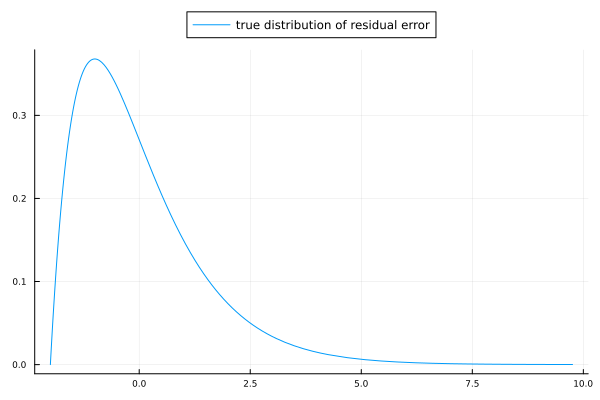

In [4]:
distx = Normal(0, 2)
_distu = Gamma(2, 1)
distu = _distu - mean(_distu)

plot(distu; label="true distribution of residual error", legend=:outertop)

β̂ = X \ y = [1.015742593915554, 1.0369889985078395]


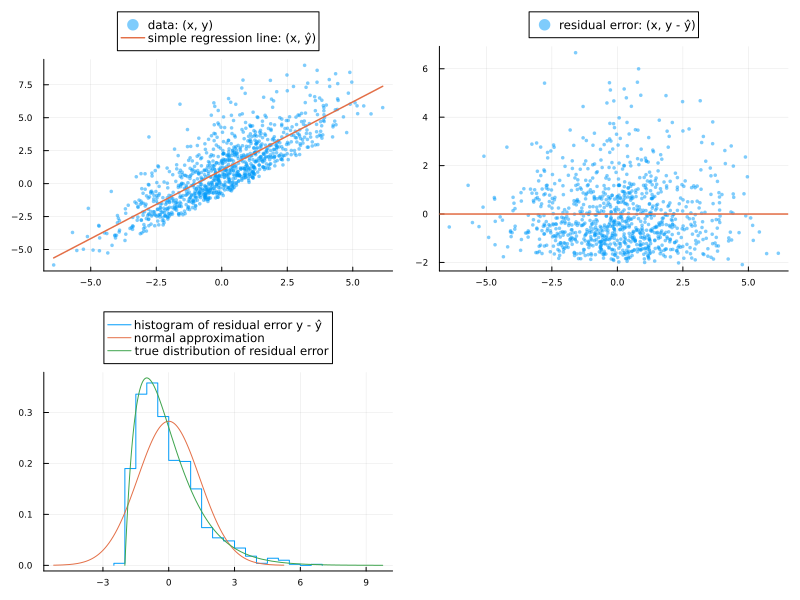

In [5]:
n = 1000
a, b = 1.0, 1.0
y = @. a + b*x + rand(distu)

X = x .^ (0:1)'
@show β̂ = X \ y
ŷ = X * β̂

P1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
plot!(x -> [1,x]'*β̂; label="simple regression line: (x, ŷ)", lw=1.5)

P2 = scatter(x, y - ŷ; label="residual error: (x, y - ŷ)", msc=:auto, alpha=0.5, ms=2)
hline!([0]; label="", lw=1.5)

P3 = stephist(y - ŷ; norm=true, label="histogram of residual error y - ŷ")
plot!(fit(Normal, y - ŷ); label="normal approximation")
plot!(distu; label="true distribution of residual error")

plot(P1, P2, P3; size=(800, 600), legend=:outertop, layout=(2, 2))

このような場合であっても, $\hat\beta$ の分布は2変量正規分布で近似される.  以下でそのことを確認しよう.

In [6]:
function sim(distx, a, b, distu, n; L=10^5)
    tmpx = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpu = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpX = [Matrix{Float64}(undef, n, 2) for _ in 1:Threads.nthreads()]
    β̂ = [Vector{Float64}(undef, 2) for _ in 1:L]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        x = rand!(distx, tmpx[tid])
        u = rand!(distu, tmpu[tid])
        y = @. tmpy[tid] = a + b*x + u
        tmpX[tid][:,1] .= 1
        tmpX[tid][:,2] .= x
        X = tmpX[tid]
        β̂[i] = X \ y
    end
    β̂
end

# 回帰係数の分布は以下の分布に漸近する.
function mvnormalapprox_true(distx, a, b, distu, n)
    μx = mean(distx)
    σx² = var(distx)
    σ² = var(distu)
    μ_true = [a, b]
    Σ_true = σ²/(n*σx²)*[σx²+μx^2 -μx; -μx 1]
    MvNormal(μ_true, Σ_true)
end

mvnormalapprox_true (generic function with 1 method)

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.002 -0.0; -0.0 0.0005]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.999871203995414, 0.9999872943992526]
Σ: [0.0019902234703776623 -3.360991868281532e-6; -3.360991868281532e-6 0.0005006421364705247]
)



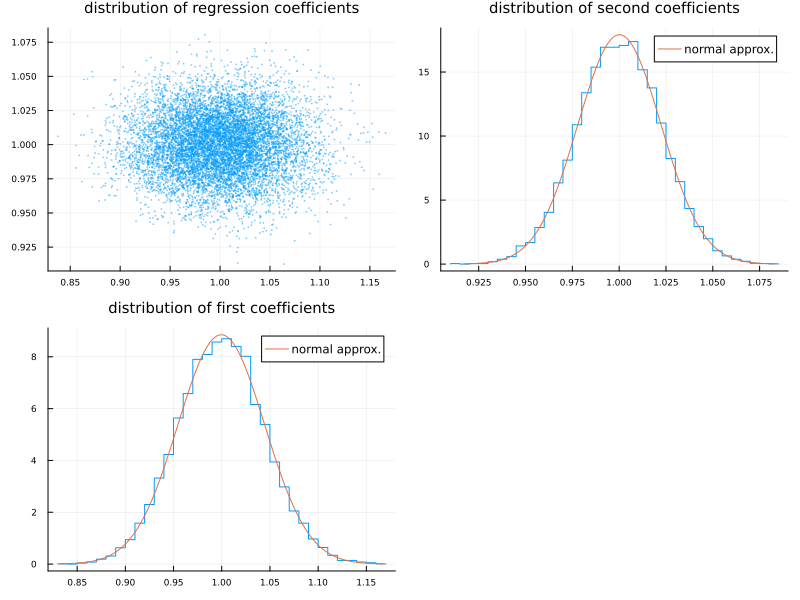

In [7]:
n = 1000
β̂ = sim(distx, a, b, distu, n)
@show mvnormalapprox_true(distx, a, b, distu, n)
@show fit(MvNormal, stack(β̂))

β̂₀, β̂₁ = getindex.(β̂, 1)[1:10000], getindex.(β̂, 2)[1:10000]
Q1 = scatter(β̂₀, β̂₁; label="", msc=:auto, alpha=0.5, ms=1)
title!("distribution of regression coefficients")
Q2 = stephist(β̂₀; norm=true, label="")
plot!(fit(Normal, β̂₀); label="normal approx.")
title!("distribution of first coefficients")
Q3 = stephist(β̂₁; norm=true, label="")
plot!(fit(Normal, β̂₁); label="normal approx.")
title!("distribution of second coefficients")

plot(Q1, Q3, Q2; size=(800, 600))

以上は標本サイズが $n=1000$ の場合である. 標本サイズが $n=20$ 程度だと正規分布近似の誤差が見える程度になる.

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.1 -0.0; -0.0 0.025]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0004752085432025, 0.9999637160327216]
Σ: [0.10658785058438125 4.24366826528452e-6; 4.24366826528452e-6 0.02942998787461804]
)



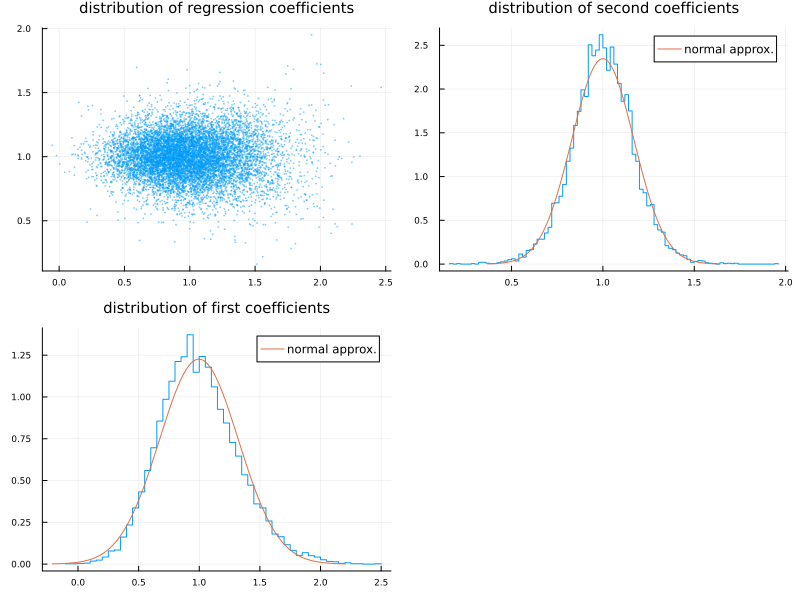

In [8]:
n = 20
β̂ = sim(distx, a, b, distu, n)
@show mvnormalapprox_true(distx, a, b, distu, n)
@show fit(MvNormal, stack(β̂))

β̂₀, β̂₁ = getindex.(β̂, 1)[1:10000], getindex.(β̂, 2)[1:10000]
Q1 = scatter(β̂₀, β̂₁; label="", msc=:auto, alpha=0.5, ms=1)
title!("distribution of regression coefficients")
Q2 = stephist(β̂₀; norm=true, label="")
plot!(fit(Normal, β̂₀); label="normal approx.")
title!("distribution of first coefficients")
Q3 = stephist(β̂₁; norm=true, label="")
plot!(fit(Normal, β̂₁); label="normal approx.")
title!("distribution of second coefficients")

plot(Q1, Q3, Q2; size=(800, 600))

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.05 -0.0; -0.0 0.0125]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.000232455492442, 1.0000804753646981]
Σ: [0.05144231813174561 -2.730595864007537e-5; -2.730595864007537e-5 0.013345615748657187]
)



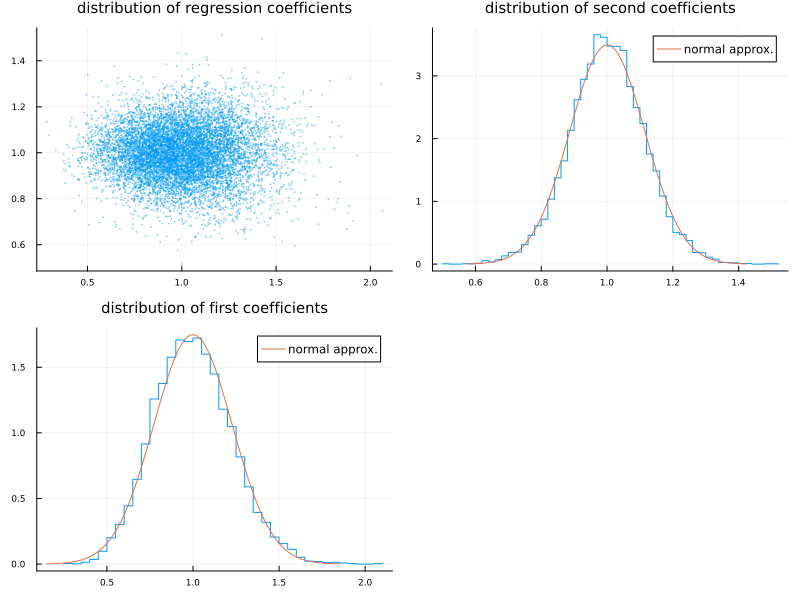

In [9]:
n = 40
β̂ = sim(distx, a, b, distu, n)
@show mvnormalapprox_true(distx, a, b, distu, n)
@show fit(MvNormal, stack(β̂))

β̂₀, β̂₁ = getindex.(β̂, 1)[1:10000], getindex.(β̂, 2)[1:10000]
Q1 = scatter(β̂₀, β̂₁; label="", msc=:auto, alpha=0.5, ms=1)
title!("distribution of regression coefficients")
Q2 = stephist(β̂₀; norm=true, label="")
plot!(fit(Normal, β̂₀); label="normal approx.")
title!("distribution of first coefficients")
Q3 = stephist(β̂₁; norm=true, label="")
plot!(fit(Normal, β̂₁); label="normal approx.")
title!("distribution of second coefficients")

plot(Q1, Q3, Q2; size=(800, 600))

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.02 -0.0; -0.0 0.005]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9999455660573827, 0.9998959031133987]
Σ: [0.02015538856213266 6.269769415363277e-5; 6.269769415363277e-5 0.005194383149627233]
)



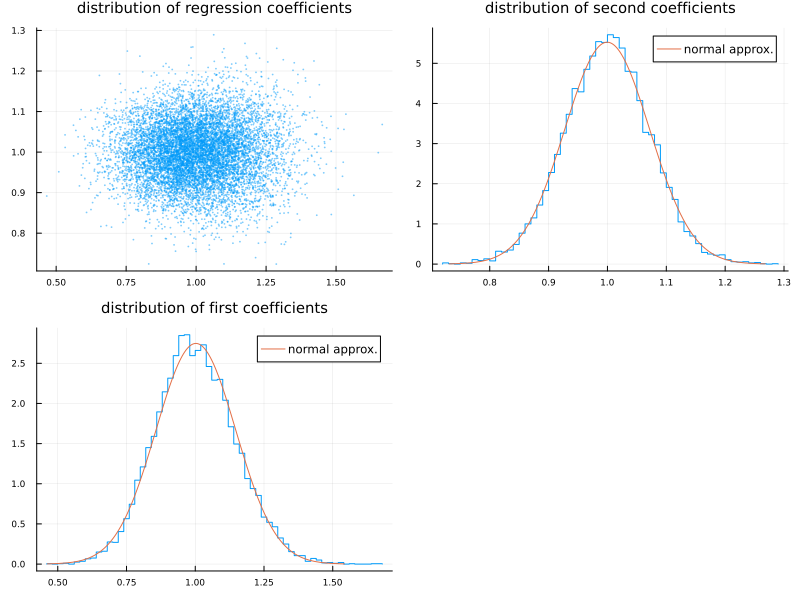

In [10]:
n = 100
β̂ = sim(distx, a, b, distu, n)
@show mvnormalapprox_true(distx, a, b, distu, n)
@show fit(MvNormal, stack(β̂))

β̂₀, β̂₁ = getindex.(β̂, 1)[1:10000], getindex.(β̂, 2)[1:10000]
Q1 = scatter(β̂₀, β̂₁; label="", msc=:auto, alpha=0.5, ms=1)
title!("distribution of regression coefficients")
Q2 = stephist(β̂₀; norm=true, label="")
plot!(fit(Normal, β̂₀); label="normal approx.")
title!("distribution of first coefficients")
Q3 = stephist(β̂₁; norm=true, label="")
plot!(fit(Normal, β̂₁); label="normal approx.")
title!("distribution of second coefficients")

plot(Q1, Q3, Q2; size=(800, 600))

このようにi.i.d.の残差の分布が正規分布でなくても, 標本サイズが十分に大きければ, 回帰係数の分布は多変量正規分布で近似される.